# Pre-processing

In [2]:
from skimage import io, color, filters
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
from skimage import io, measure
import scipy

In [3]:
# directory = '/media/Saturday/Data_backup/Nasher2022/nasher_day4/1973.1_20220325_113521_177/'
# filename = 'reconstruction_20231109_021219_438.mat'

directory = '/media/Saturday/Data_backup/Nasher2022/nasher_day1/Cypriot_2006.1_7120220322_122747_148/'
filename = 'reconstruction_20231103_040252_353.mat'
data = loadmat(os.path.join(directory,filename))  # Replace with your file path
recon_full = data['reconstruction']

In [4]:
recon_full.shape

(16000, 13000, 4)

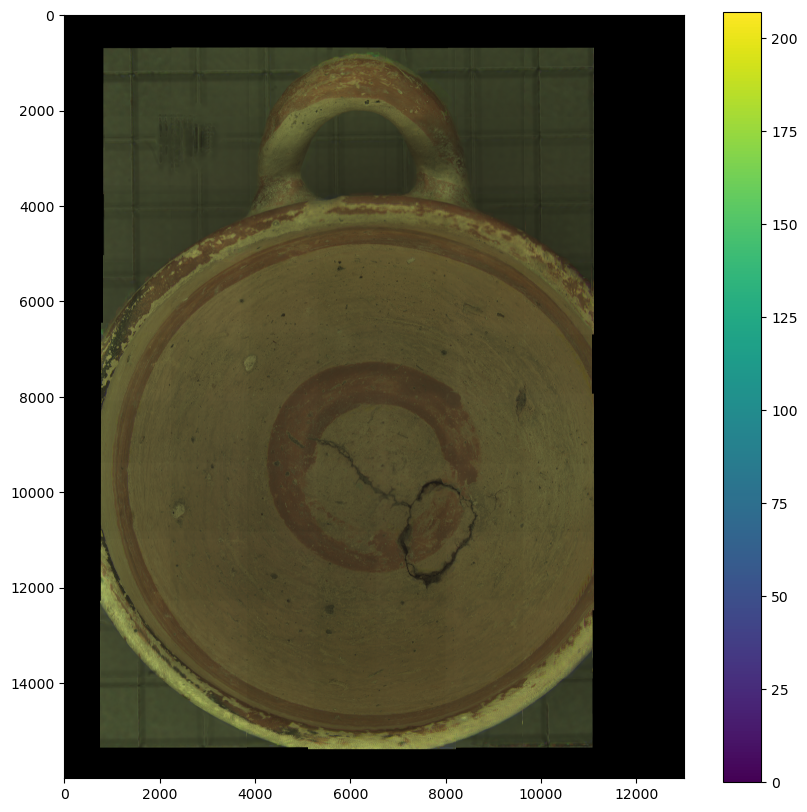

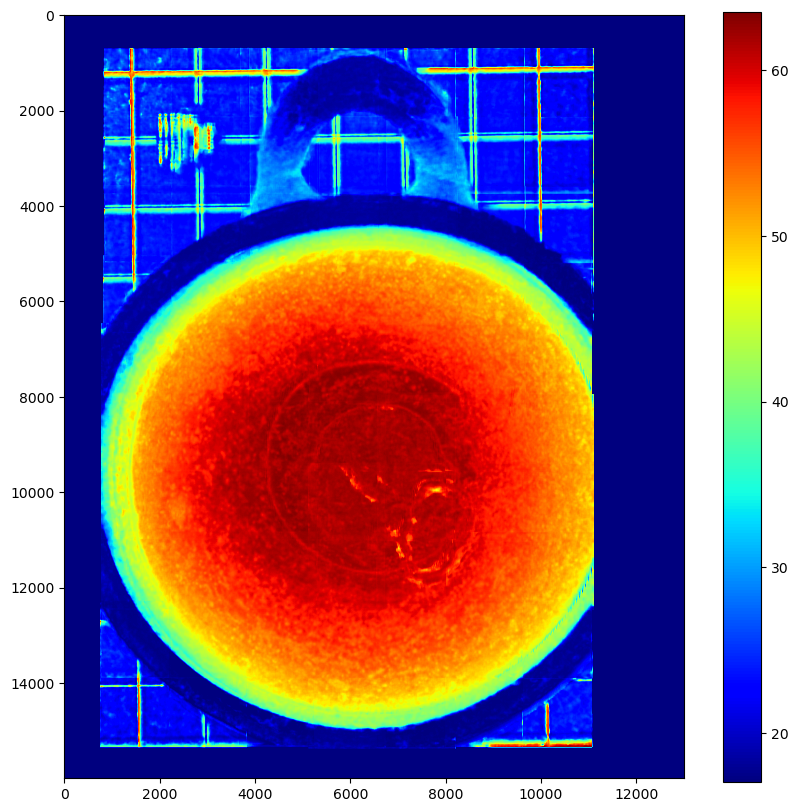

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(recon_full[:, :, :-1].astype(np.uint8).squeeze()) #FIXME
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(recon_full[:, :, -1], cmap='jet')
clims = np.percentile(recon_full[::4,::4, -1][recon_full[::4,::4, -1]!=0], [0.5, 99.99])
plt.clim(clims)
plt.colorbar()
plt.show()

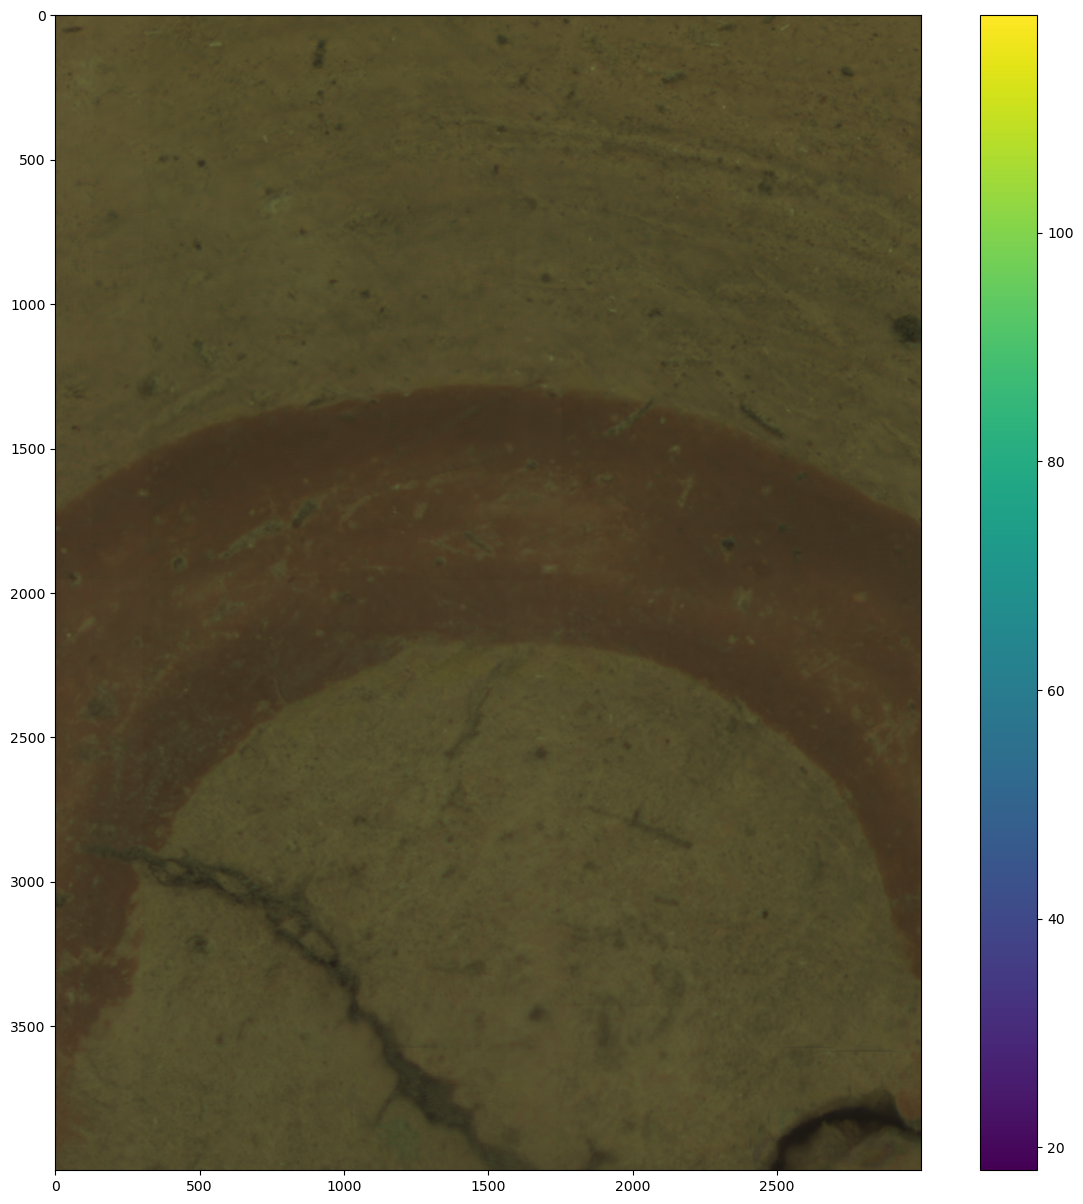

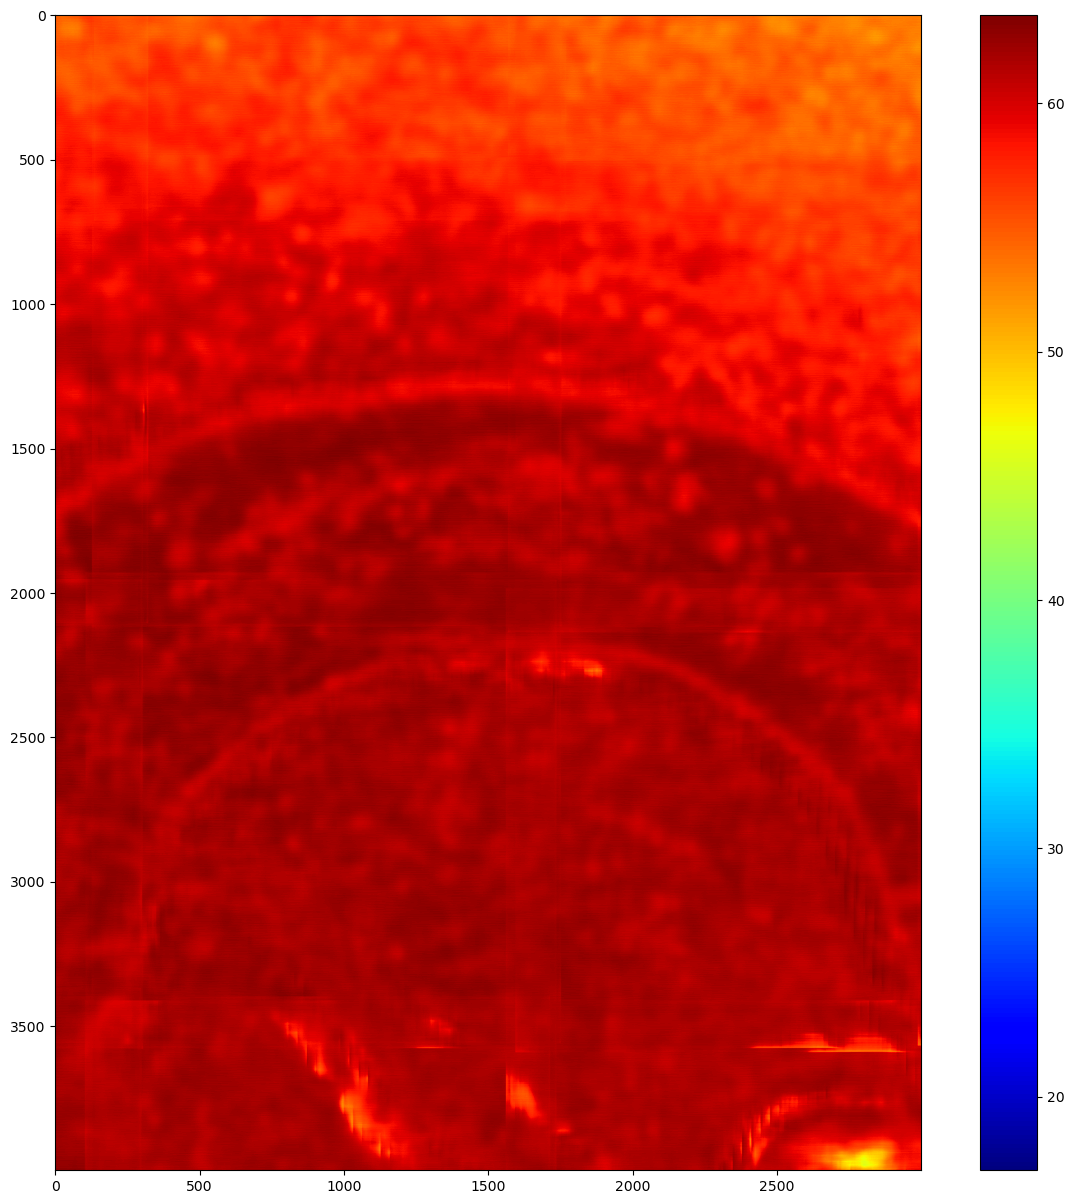

In [6]:
# more zoomed in:
plt.figure(figsize=(15,15))
plt.imshow(recon_full[6000:10000,5000:8000,:-1].astype(np.uint8).squeeze())
plt.colorbar()
plt.show()
plt.figure(figsize=(15,15))
plt.imshow(recon_full[6000:10000,5000:8000,-1],cmap='jet')
clims = np.percentile(recon_full[::4,::4, -1][recon_full[::4,::4, -1]!=0], [0.5, 99.99])
plt.clim(clims)
plt.colorbar()
plt.show()

## bilateral filter

In [7]:
def bilateral_filter_cpu(trial_im, sigma_s, sigma_r):
    '''
    Source:Amey
    '''
    max_pix_range = int(trial_im.max())
    # trial_im = trial_im.get()
    Gamma_intensity = np.zeros((*trial_im.shape, max_pix_range+1), dtype=np.float32)
    Gamma_weight = np.zeros((*trial_im.shape, max_pix_range+1), dtype=np.float32)
    idx = np.indices(Gamma_intensity.shape)
    Gamma_intensity[idx[0], idx[1], trial_im[idx[0], idx[1]].astype(int)] = trial_im[idx[0], idx[1]]
    Gamma_weight[idx[0], idx[1], trial_im[idx[0], idx[1]].astype(int)] = 1
    filt_intensity = scipy.ndimage.gaussian_filter(Gamma_intensity, sigma=(sigma_s, sigma_s, sigma_r))
    del(Gamma_intensity)
    filt_weight = scipy.ndimage.gaussian_filter(Gamma_weight, sigma=(sigma_s, sigma_s, sigma_r))
    del(Gamma_weight)
    image = np.divide(filt_intensity, filt_weight)
    image = image[idx[0], idx[1], trial_im[idx[0], idx[1]].astype(int)][:,:,0]
   
    return image

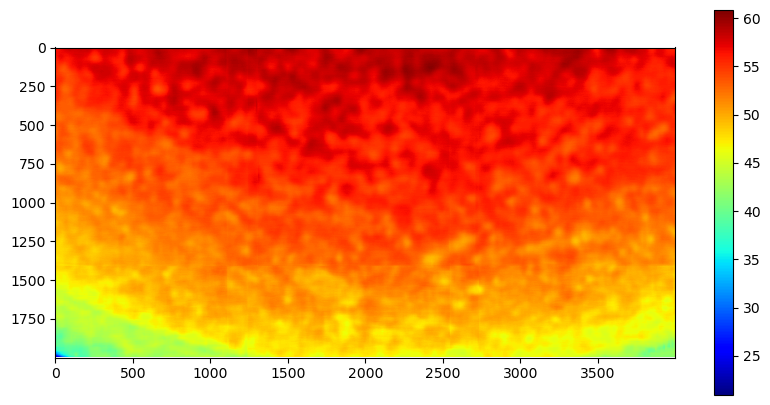

In [8]:
# The region that we care about
recon_height = recon_full[12500:14500,4000:8000,-1]
plt.figure(figsize=(10,5))
plt.imshow(recon_height,cmap='jet')
plt.colorbar()
plt.show()

/tmp/ipykernel_693303/2512709213.py:16: RuntimeWarning: invalid value encountered in divide
  image = np.divide(filt_intensity, filt_weight)


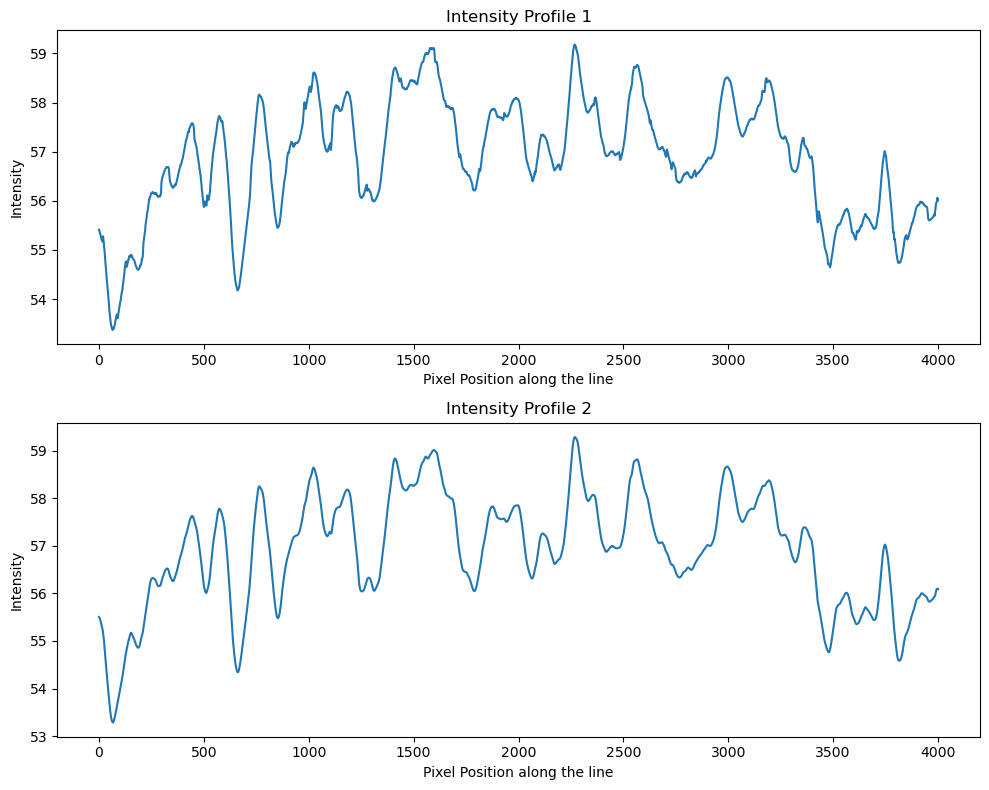

In [9]:
# Define start and end points of the line segment (x0, y0) to (x1, y1)
# Example for a horizontal line at y=50
x0, y0 = 0, 250
x1, y1 = recon_height.shape[1], 250  # image.shape[1] is the width of the image
profile1 = measure.profile_line(recon_height, (y0, x0), (y1, x1))

# Do bilatral filtering
bilateral_img = bilateral_filter_cpu(recon_height,3,3)

# Make the other profile
profile2 = measure.profile_line(bilateral_img, (y0, x0), (y1, x1))

# PLOT
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # 两个子图，总体大小为10x8英寸

ax1.plot(profile1)
ax1.set_title('Intensity Profile 1')
ax1.set_xlabel('Pixel Position along the line')
ax1.set_ylabel('Intensity')

ax2.plot(profile2)
ax2.set_title('Intensity Profile 2')
ax2.set_xlabel('Pixel Position along the line')
ax2.set_ylabel('Intensity')

# DISPLAY
plt.tight_layout()  # adjust two plots' distance
plt.show()

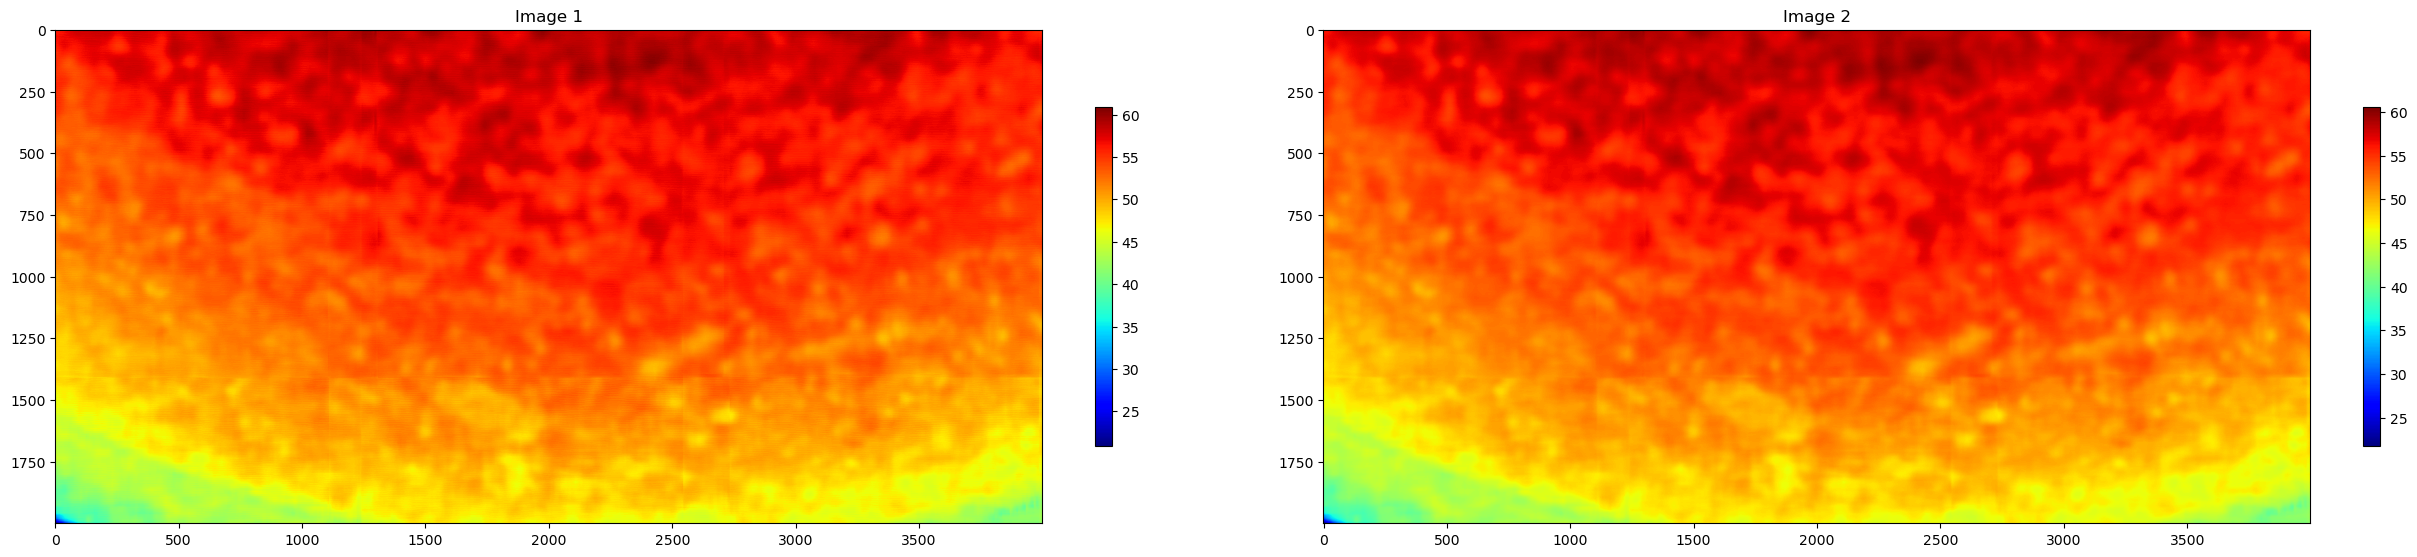

In [10]:
# PLOT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

im1 = ax1.imshow(recon_height, cmap='jet')
ax1.set_title('Image 1')
fig.colorbar(im1, ax=ax1, fraction=0.016) 

im2 = ax2.imshow(bilateral_img, cmap='jet')
ax2.set_title('Image 2')
fig.colorbar(im2, ax=ax2, fraction=0.016) 

# 显示整个图表
plt.show()


# Unsharp masking

In [11]:
# Conclusion:seems like what unsharp masking does is to make little peaks more apparent to observe. as you can see the examples 
# from https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html

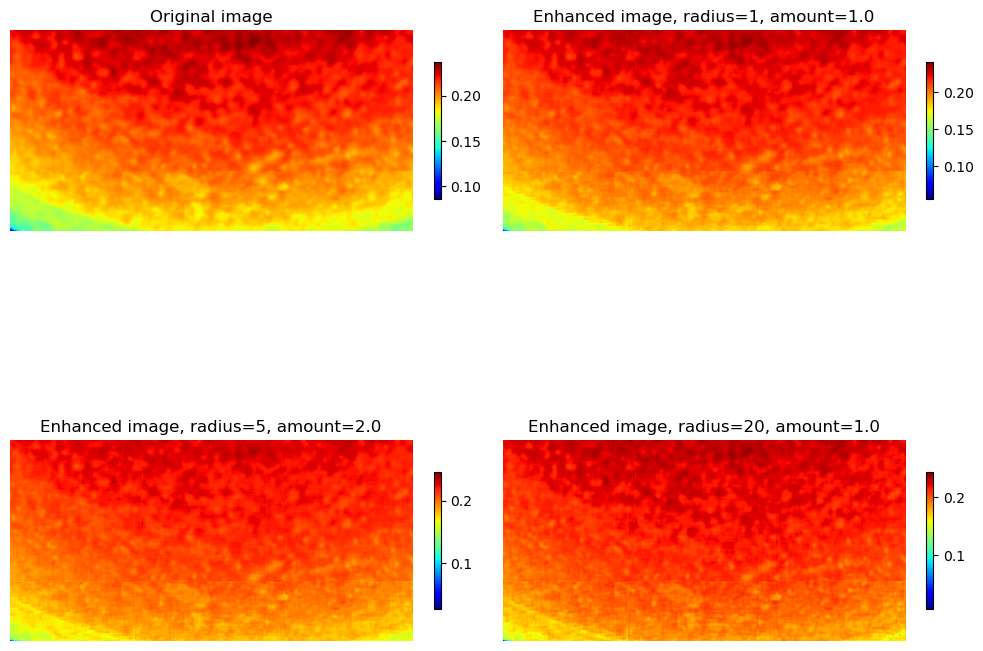

In [12]:
from skimage.filters import unsharp_mask
import matplotlib.pyplot as plt

image = bilateral_img  #.astype(np.uint8)
image = image/255.0
result_1 = unsharp_mask(image, radius=5, amount=5)
result_2 = unsharp_mask(image, radius=5, amount=10)
result_3 = unsharp_mask(image, radius=10, amount=5)

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

im0 = ax[0].imshow(image, cmap=plt.cm.jet)
ax[0].set_title('Original image')
fig.colorbar(im0, ax=ax[0],fraction=0.016)  # Add colorbar

im1 = ax[1].imshow(result_1, cmap=plt.cm.jet)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
fig.colorbar(im1, ax=ax[1],fraction=0.016)  # Add colorbar

im2 = ax[2].imshow(result_2, cmap=plt.cm.jet)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
fig.colorbar(im2, ax=ax[2],fraction=0.016)  # Add colorbar

im3 = ax[3].imshow(result_3, cmap=plt.cm.jet)
ax[3].set_title('Enhanced image, radius=20, amount=1.0')
fig.colorbar(im3, ax=ax[3],fraction=0.016)  # Add colorbar

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

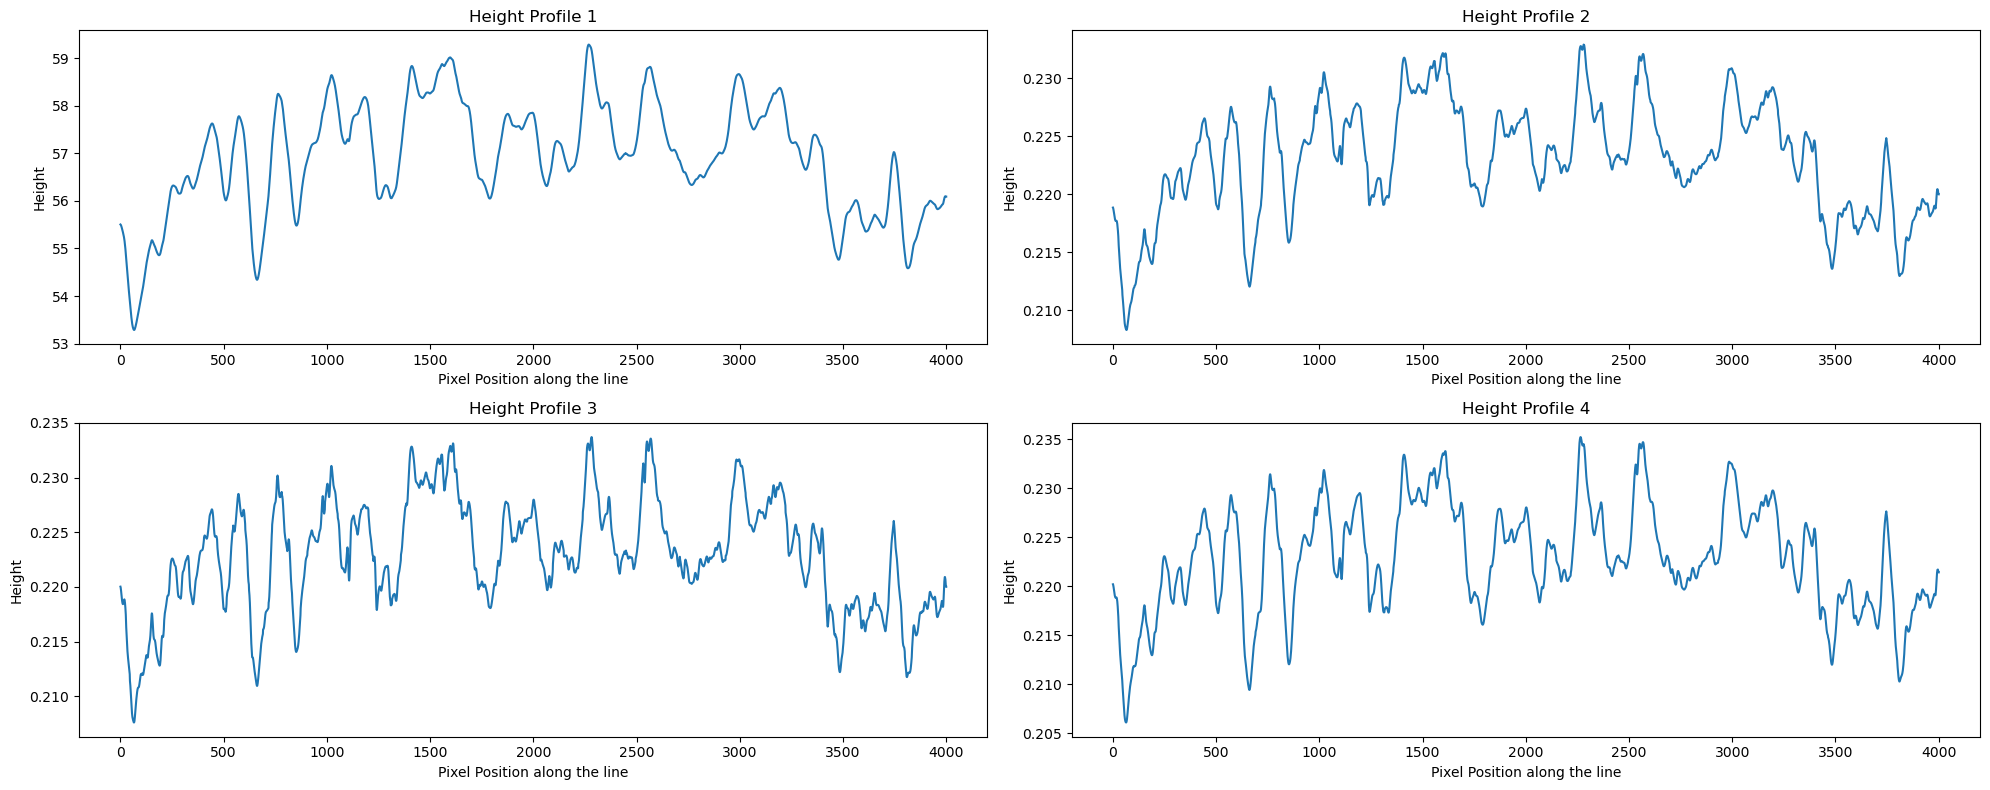

In [13]:
# Define start and end points of the line segment (x0, y0) to (x1, y1)
# Example for a horizontal line at y=50
x0, y0 = 0, 250
x1, y1 = recon_height.shape[1], 250  # image.shape[1] is the width of the image
profile0 = measure.profile_line(bilateral_img, (y0, x0), (y1, x1))

# Make other profiles
profile1 = measure.profile_line(result_1, (y0, x0), (y1, x1))
profile2 = measure.profile_line(result_2, (y0, x0), (y1, x1))
profile3 = measure.profile_line(result_3, (y0, x0), (y1, x1))

# PLOT
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 8))  

ax0.plot(profile0)
ax0.set_title('Height Profile 1')
ax0.set_xlabel('Pixel Position along the line')
ax0.set_ylabel('Height')

ax1.plot(profile1)
ax1.set_title('Height Profile 2')
ax1.set_xlabel('Pixel Position along the line')
ax1.set_ylabel('Height')

ax2.plot(profile2)
ax2.set_title('Height Profile 3')
ax2.set_xlabel('Pixel Position along the line')
ax2.set_ylabel('Height')

ax3.plot(profile3)
ax3.set_title('Height Profile 4')
ax3.set_xlabel('Pixel Position along the line')
ax3.set_ylabel('Height')

# DISPLAY
plt.tight_layout() 
plt.show()

# Peak detection

(2000, 4000)


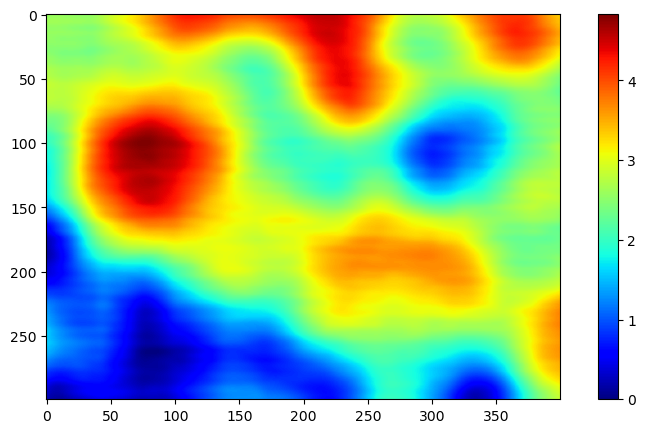

In [14]:
print(bilateral_img.shape)
# Crop one patch
image = bilateral_img[800:1100,1800:2200]
image -= image.min()
plt.figure(figsize=(10,5))
plt.imshow(image,cmap='jet')
plt.colorbar()
plt.show()

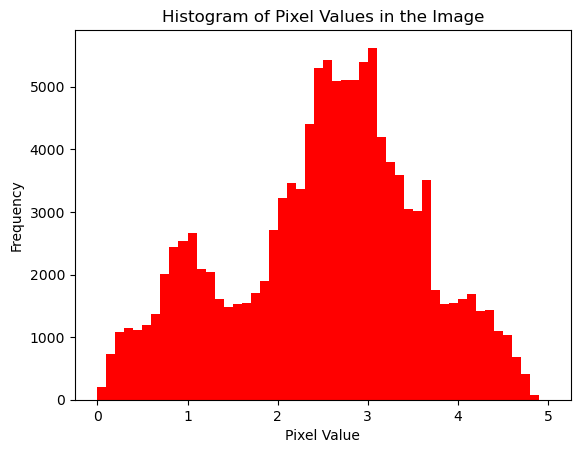

In [15]:
hist, bins = np.histogram(image.flatten(), bins=50, range=[0,5])

# Plotting the histogram
plt.hist(image.flatten(), bins=50, range=[0,5], color='r')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Values in the Image')
plt.show()

In [16]:
first_percentile = np.percentile(image, 1)
print(first_percentile)
fifth_percentile = np.percentile(image, 5)
print(fifth_percentile)
tenth_percentile = np.percentile(image,10)
print(tenth_percentile)

0.2269771194458008
0.6457725524902345
0.9330963134765626


In [17]:
import numpy as np
from scipy.ndimage import maximum_filter
from scipy.ndimage import generate_binary_structure, binary_erosion

def detect_peaks(image,tenth_percentile):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    Reference: https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array
    """

    # define an 8-connected neighborhood #FIXME
    a,b = image.shape
    l = int(min(a,b)/6)
    neighborhood = np.ones((20,20),dtype=bool)#generate_binary_structure(5,5)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that CONTAINS the peaks we are looking for, but also the BACKGROUND.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image<=tenth_percentile) #FIXME

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

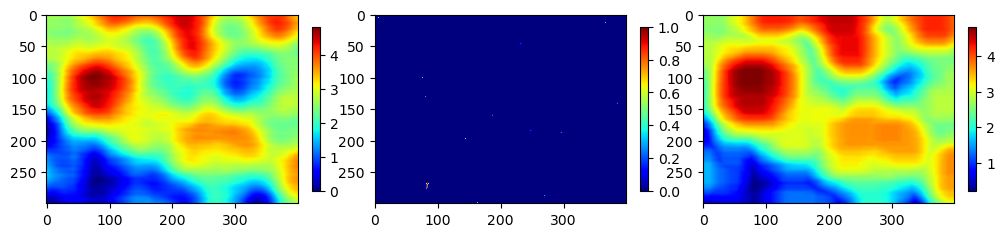

In [18]:
# Simply applying maximum filter has opposite effect
detected_peaks = detect_peaks(image,first_percentile)
plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
plt.imshow(image,cmap='jet')
plt.colorbar(fraction=0.03)
plt.subplot(1,3,2)
plt.imshow(detected_peaks,cmap='jet')
plt.colorbar(fraction=0.03)
plt.subplot(1,3,3)
plt.imshow(maximum_filter(image, footprint=np.ones((20,20),dtype=bool)),cmap='jet')
plt.colorbar(fraction=0.03)
plt.show()

In [19]:
np.sum(detected_peaks)

39

Maybe we can also try to do gradient and detect peaks.

### Simply Applying Median Filter

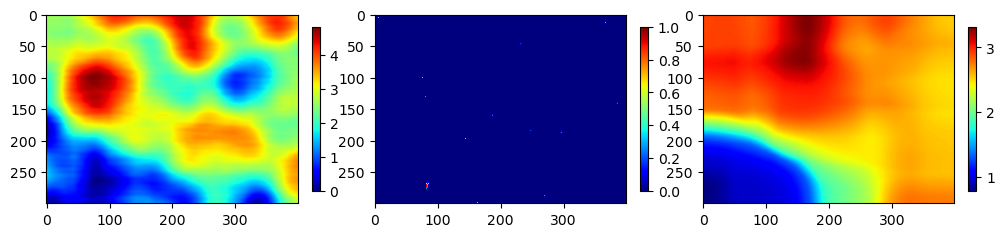

In [20]:
from scipy.ndimage import median_filter
# size=200
filtered_image_200 = median_filter(image, size=200)
plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
plt.imshow(image,cmap='jet')
plt.colorbar(fraction=0.03)
plt.subplot(1,3,2)
plt.imshow(detected_peaks,cmap='jet')
plt.colorbar(fraction=0.03)
plt.subplot(1,3,3)
plt.imshow(filtered_image_200,cmap='jet')
plt.colorbar(fraction=0.03)
plt.show()

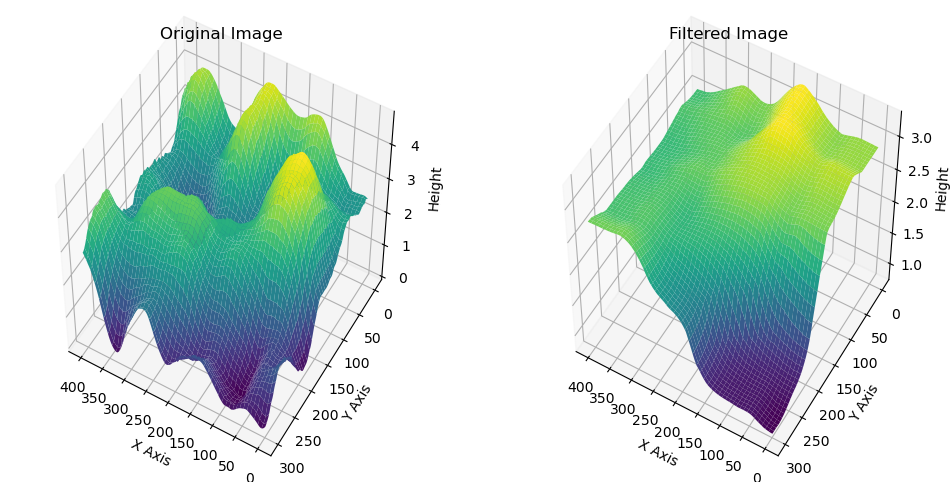

In [21]:
from mpl_toolkits.mplot3d import Axes3D

image = bilateral_img[800:1100,1800:2200]
image -= image.min()
x = np.arange(image.shape[1])  
y = np.arange(image.shape[0])  
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')  
ax1.plot_surface(x, y, image, cmap='viridis')
ax1.set_title('Original Image')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Height')
ax1.view_init(elev=50, azim=120)

ax2 = fig.add_subplot(122, projection='3d')  
ax2.plot_surface(x, y, filtered_image_200, cmap='viridis')
ax2.set_title('Filtered Image')
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Y Axis')
ax2.set_zlabel('Height')
ax2.view_init(elev=50, azim=120)

plt.show()

Code executed in 146.37642240524292 seconds


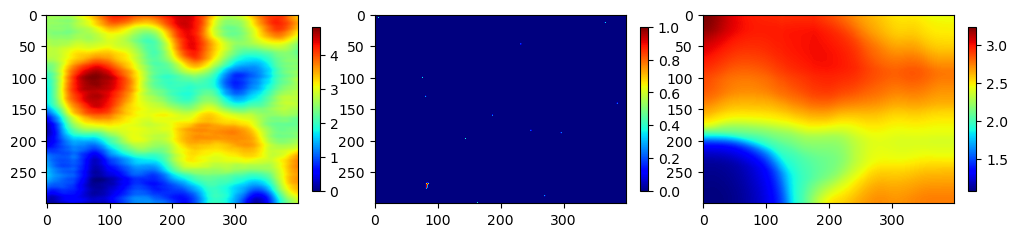

In [35]:
# size=300 is nearly the size of the entire image, and it takes a long time to run
from scipy.ndimage import median_filter
import time

start_time = time.time()
filtered_image_300 = median_filter(image, size=300)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Code executed in {elapsed_time} seconds")

plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
plt.imshow(image,cmap='jet')
plt.colorbar(fraction=0.03)
plt.subplot(1,3,2)
plt.imshow(detected_peaks,cmap='jet')
plt.colorbar(fraction=0.03)
plt.subplot(1,3,3)
plt.imshow(filtered_image_300,cmap='jet')
plt.colorbar(fraction=0.03)
plt.show()


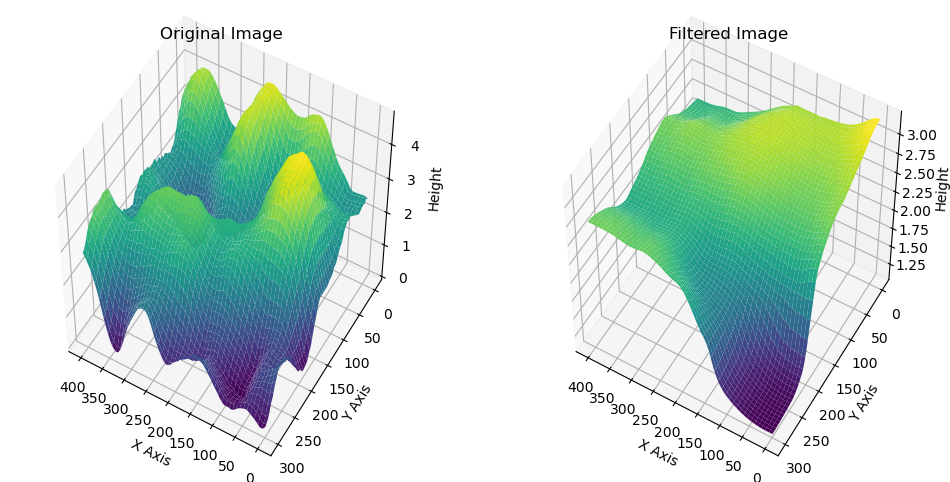

In [23]:
image = bilateral_img[800:1100,1800:2200]
image -= image.min()
x = np.arange(image.shape[1])  
y = np.arange(image.shape[0])  
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')  
ax1.plot_surface(x, y, image, cmap='viridis')
ax1.set_title('Original Image')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Height')
ax1.view_init(elev=50, azim=120)

ax2 = fig.add_subplot(122, projection='3d')  
ax2.plot_surface(x, y, filtered_image_300, cmap='viridis')
ax2.set_title('Filtered Image')
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Y Axis')
ax2.set_zlabel('Height')
ax2.view_init(elev=50, azim=120)

plt.show()

### Around-Peak median filtering (Adaptive)

Code executed in 144.33530592918396 seconds


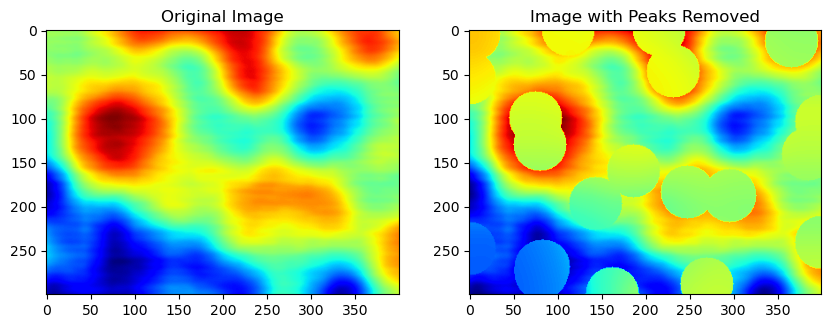

In [42]:
import numpy as np
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from scipy.ndimage import generate_binary_structure
from scipy.ndimage import generic_filter

# def adaptive_filter(pixel, footprint, peak_locations):
#     local_median = np.median(footprint)
#     if pixel == False:
#         return pixel
#     else:
#         return local_median
    
# global_mean = np.mean(image)
# global_std = np.std(image)

# Assuming 'image' is your NumPy array containing the image data
# And 'peak_locations' is a boolean array where True indicates a peak

# generate around-peak matrix which is mainly draw a circle around each peak
radius = min(detected_peaks.shape) // 10
# structure = generate_binary_structure(2, 1)
# structure = binary_dilation(structure, iterations=radius)
y, x = np.ogrid[-radius: radius+1, -radius: radius+1]
mask = x**2 + y**2 <= radius**2
structure = mask.astype(int)
expanded_peaks = binary_dilation(detected_peaks, structure=structure)


# Apply median filter selectively on around-peak locations
image = bilateral_img[800:1100,1800:2200]
image -= image.min()
start_time = time.time()
filtered_image = np.copy(image)
filtered_image[expanded_peaks] = median_filter(image, size=300)[expanded_peaks]
# filtered_image = generic_filter(image, function=adaptive_filter, footprint=structure,
#                                 extra_arguments=(expanded_peaks,))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Code executed in {elapsed_time} seconds")


# Display the original and filtered images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='jet')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='jet')
plt.title('Image with Peaks Removed')
plt.show()


### Improve region selection

In [ ]:
# Aparently this method decide the around-peak region too casually, so I plan to try adaptive filtering.

### gaussian filtering

In [ ]:
# might be the similar effect as median filtering.
# save for future discussion

## Other(Not implemented)

There are plenty of other algorithms in the article you sent to me: https://www.sciencedirect.com/science/article/pii/S2772671123000050?ref=pdf_download&fr=RR-2&rr=82dcb487daa88c9b

but I guess I need other types of peak in different reconstrction results to test.

If the peak is significantly high, we can just clip them, which I thought is the case in last lab meeting, or we can try morphological opening (erosion followed by dilation) , for which I need the reconstrcution result from you.